In [85]:
import cv2
import numpy as np
import os
import matplotlib.pylab as plt



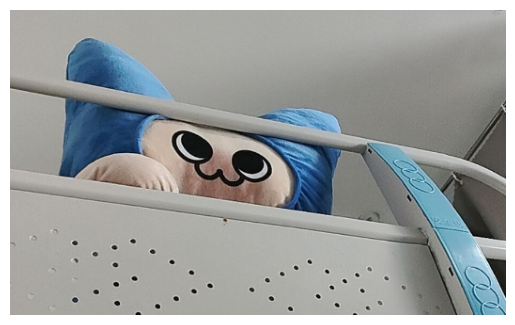

In [30]:
picture=cv2.imread('image.png')
gray_picture=cv2.imread('image.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(picture, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

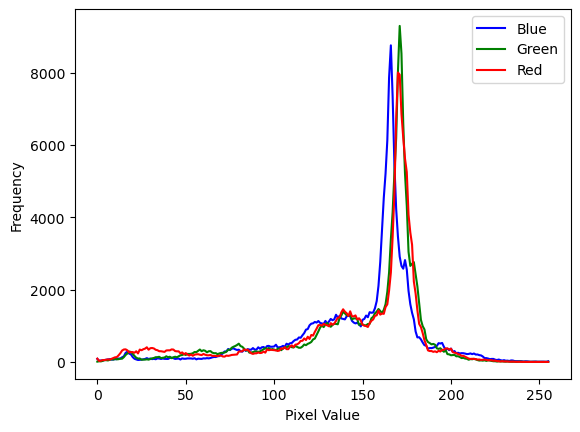

In [31]:
# 直方图
def calculate_histogram(image):
    histogram = np.zeros((256, 3))
    h, w, _ = image.shape
    for i in range(h):
        for j in range(w):
            for k in range(3): # B G R
                histogram[image[i, j, k], k] += 1
    return histogram


# 计算颜色直方图
color_histogram = calculate_histogram(picture)

# 绘制颜色直方图，指定颜色
plt.plot(color_histogram[:, 0], color='b')
plt.plot(color_histogram[:, 1], color='g')
plt.plot(color_histogram[:, 2], color='r')
plt.legend(['Blue', 'Green', 'Red'])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [76]:

# 纹理特征提取

# GLCM (全局)
def get_glcm_features(image,angle=0):
    h, w = image.shape
    glcm = np.zeros((256, 256))

    if angle==0:  # -->
        for i in range(h):
            for j in range(w):
                try:
                    glcm[image[i, j], image[i, j+1]] += 1
                except:
                    pass
    elif angle == 45:  # ↗
        for i in range(h):
            for j in range(w):
                try:
                    glcm[image[i, j], image[i+1, j-1]] += 1
                except:
                    pass
    elif angle == 90:  # ↑
        for i in range(h):
            for j in range(w):
                try:
                    glcm[image[i, j], image[i, j-1]] += 1
                except:
                    pass           
    else:  # angle == 135:  # ↖
        for i in range(h):
            for j in range(w):
                try:
                    glcm[image[i, j], image[i-1, j-1]] += 1
                except:
                    pass                
    
    glcm = glcm / np.sum(glcm) #转为频率
                
    contrast = 0  #对比度
    dissimilarity = 0 #相异性
    homogeneity = 0 #同质性
    entropy = 0 # 熵
    correlation = 0 #相关性
    ASM = 0   # 角二阶矩/能量
    
    mean_i = np.mean(image)
    mean_j = np.mean(image)
    std_i = np.std(image)
    std_j = np.std(image)
    
    for i in range(256):
        for j in range(256):
            contrast += (i - j)**2 * glcm[i, j]
            dissimilarity += abs(i - j) * glcm[i, j]
            homogeneity += glcm[i, j] / (1 + abs(i - j))
            if glcm[i, j] > 0:
                entropy += glcm[i, j] * np.log(glcm[i, j])
            correlation += ((i - mean_i) * (j - mean_j) * glcm[i, j]) / (std_i * std_j)
            ASM += glcm[i, j]**2
    
    return glcm,np.array([contrast,dissimilarity,homogeneity,entropy,correlation,ASM])
glcm_example=np.array([[0,1,2],[0,1,2],[0,1,2]])
glcm,glcm_features = get_glcm_features(glcm_example)
print(glcm_example)
print(glcm)
print(glcm_features)


[[0 1 2]
 [0 1 2]
 [0 1 2]]
[[0.  0.5 0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]
[ 1.          1.          0.5        -0.69314718  0.          0.5       ]


In [77]:
GLCM,GLCM_features = get_glcm_features(gray_picture,angle=0)
print(GLCM)
print(GLCM_features)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.83856371e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.83856371e-06 0.00000000e+00 1.75156911e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[ 1.61892839e+02  4.62710845e+00  4.61586892e-01 -7.27465438e+00
  9.46588173e-01  2.96044565e-03]


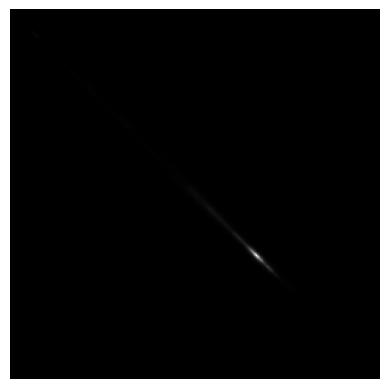

In [79]:
plt.imshow(GLCM, cmap='gray')
plt.axis('off')
plt.show()

In [82]:
# LBP （局部）
def get_lbp_features(image):
     # 窗口中心的像素点作为中心，该像素点的像素值作为阈值。然后将周围8个像素点的灰度值与该阈值进行比较
     # 若周围某像素值大于中心像素值，则该像素点位置被标记为1；反之，该像素点标记为0。
    h, w = image.shape
    lbp_image = np.zeros((h, w), dtype=np.uint8)
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            center = image[i, j]
            binary_string = ''
            binary_string += '1' if image[i-1, j-1] > center else '0'
            binary_string += '1' if image[i-1, j] > center else '0'
            binary_string += '1' if image[i-1, j+1] > center else '0'
            binary_string += '1' if image[i, j+1] > center else '0'
            binary_string += '1' if image[i+1, j+1] > center else '0'
            binary_string += '1' if image[i+1, j] > center else '0'
            binary_string += '1' if image[i+1, j-1] > center else '0'
            binary_string += '1' if image[i, j-1] > center else '0'
            lbp_image[i, j] = int(binary_string, 2)
    
    return lbp_image

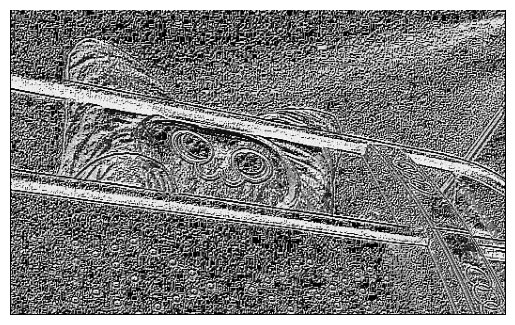

In [83]:
LBP_features=get_lbp_features(gray_picture)
plt.imshow(LBP_features, cmap='gray')
plt.axis('off')
plt.show()

In [84]:
# 保存纹理特征至npy格式
np.save('GLCM_features.npy', GLCM_features)
np.save('LBP_features.npy',LBP_features)

In [86]:
# 卷积操作
def convolve(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(image)
    
    for i in range(h):
        for j in range(w):
            region = padded_image[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)

    return output


p= np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
k=np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]]) #右移
print(p)
print(k)
print(convolve(p,k))


[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
[[0 0 0]
 [1 0 0]
 [0 0 0]]
[[0 1 0]
 [0 2 0]
 [0 1 0]]


In [87]:
# sobel算子
def sobel_filter(image, axis):
    if axis == 0:
        kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]) #x
    else:
        kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) #y
    return convolve(image, kernel)

In [89]:
def filt_image(image):
    
    # Sobel算子滤波
    sobelx = sobel_filter(image, axis=0)
    sobely = sobel_filter(image, axis=1)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    
    # 给定卷积核滤波
    kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    filtered_image = convolve(image, kernel)
    return sobel,filtered_image
    
sobel_image,kernel_iamge=filt_image(gray_picture)

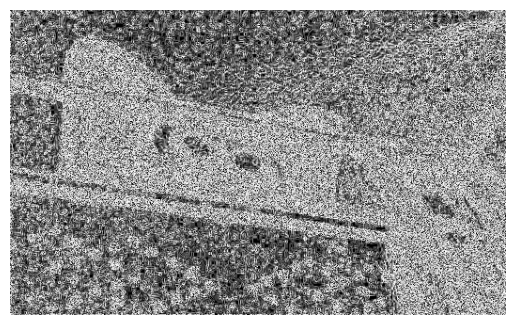

In [90]:

plt.imshow(sobel_image, cmap='gray')
plt.axis('off')
plt.show()

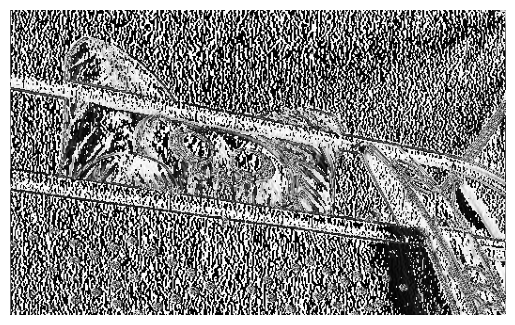

In [91]:

plt.imshow(kernel_iamge, cmap='gray')
plt.axis('off')
plt.show()

In [92]:
#边缘检测
#之前写的canny边缘检测
#非最大值抑制处理(细化边缘)
def non_maximum_suppression(magnitude, direction):
    """
    1.对于每个像素点，根据其梯度方向，将其与梯度方向相邻的两个像素点进行比较。
    2.如果当前像素点的梯度幅值大于相邻的两个像素点，则保留该像素点的梯度幅值。
    3.否则，将当前像素点的梯度幅值设为零
    """
    M, N = magnitude.shape
    res = np.zeros((M, N), dtype=np.int32)
    angle = direction * 180. / np.pi    #弧度转角度
    angle[angle < 0] += 180             #取正角度

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                #选择梯度方向上相邻的两个像素点
                q = 255
                r = 255
                # angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                # angle 45
                elif 22.5 <= angle[i, j] < 67.5:
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                # angle 90
                elif 67.5 <= angle[i, j] < 112.5:
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                # angle 135
                elif 112.5 <= angle[i, j] < 157.5:
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                #保留或抑制
                if (magnitude[i, j] >= q) and (magnitude[i, j] >= r):
                    res[i, j] = magnitude[i, j]
                else:
                    res[i, j] = 0
                    
            except IndexError as e:
                pass
    return res

#双阈值处理
def double_threshold(edges,lowThreshold, highThreshold):
    highThreshold = edges.max() * highThreshold
    lowThreshold = highThreshold * lowThreshold
    print(f'max:{edges.max()} high:{highThreshold} low:{lowThreshold}')
    """
    1.如果像素的梯度幅值大于等于高阈值，则将其标记为强边缘。
    2.介于低阈值和高阈值之间，则将其标记为弱边缘。
    3.小于低阈值，则将其标记为非边缘。
    """
    print(edges)
    strong_i, strong_j= np.where(edges >= highThreshold)
    weak_i, weak_j = np.where((edges <= highThreshold) & (edges >= lowThreshold))
    zeros_i, zeros_j = np.where(edges < lowThreshold)
    edges[zeros_i, zeros_j] = 0
    
    strong_edges = np.zeros(edges.shape, dtype=bool)
    weak_edges = np.zeros(edges.shape, dtype=bool)
    strong_edges[strong_i, strong_j] = True
    weak_edges[weak_i, weak_j] = True
    
    return edges,strong_edges,weak_edges

#滞后阈值处理（连接边缘）
def hysteresis(edges,strong,weak):
    #强边缘作为起始，弱边缘连接到强边缘
    M, N = edges.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if weak[i,j]: #如果是弱边缘
                try:
                    #检查周围8个像素是否有强边缘
                    if (strong[i,j+1] or strong[i,j-1] or strong[i+1,j] or strong[i-1,j]or
                        strong[i-1,j-1] or strong[i+1,j+1] or strong[i-1,j+1] or strong[i+1,j-1]):
                        #有则设置为强边缘，否则消去
                        pass
                    else:
                        edges[i, j] = 0
                except IndexError as e:
                    pass
    return edges

def my_detector(image,kernel_size=5,sigma=1.67,high=0.4,low=0.5):
    #平滑
    kernel=cv2.getGaussianKernel(kernel_size,sigma)  #使用高斯核进行平滑处理
    gaussian_kernel=kernel*kernel.T  
    blur=cv2.filter2D(image,-1,gaussian_kernel)
    #边缘增强
    #sobel核矩阵
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) #水平方向
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) #垂直方向
    #获取梯度
    Ix = cv2.filter2D(blur, -1, Kx)
    Iy = cv2.filter2D(blur, -1, Ky)
    #梯度值和方向
    magnitude = np.sqrt(Ix**2 + Iy**2)
    direction = np.arctan2(Iy, Ix)
    #非最大值边缘抑制（边缘细化）
    edges=non_maximum_suppression(magnitude,direction)
    # alpha=blur.max()/edges.max()
    # cv2.imshow('NMS',cv2.convertScaleAbs(edges,alpha=alpha))
    #双阈值检测
    threshold_image,strong,weak=double_threshold(edges,highThreshold=high,lowThreshold=low)
    #边缘连接
    final_image=hysteresis(threshold_image,strong,weak)
    #梯度值放大到像素值
    alpha=blur.max()/final_image.max()
    final_image=cv2.convertScaleAbs(final_image,alpha=alpha)
    return final_image

max:15 high:7.5 low:3.75
[[ 0  0  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 [ 0  0  1 ... 10  0  0]
 ...
 [ 0  0  0 ...  0 15  0]
 [ 0  4  0 ... 11  0  0]
 [ 0  0  0 ...  0  0  0]]


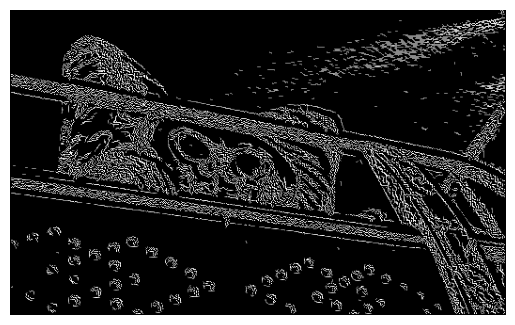

In [119]:
edges=my_detector(gray_picture,kernel_size=5,sigma=2,high=0.5,low=0.5)

plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()